# Imports

In [49]:
import pandas as pd
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import train_test_split,GridSearchCV, HalvingGridSearchCV, ParameterGrid

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    mean_squared_error,
    RocCurveDisplay,
    make_scorer,
    r2_score,
    confusion_matrix
)
from sklearn import preprocessing

import matplotlib.pyplot as plt
import xgboost as xg
import numpy as np

# Helpers

In [50]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Preprocessing

In [58]:
df = pd.read_csv('s3://fintech540-ml/staging/transform/RETURNS_GAS_IND_TARGET.csv')

/var/folders/yn/44g9c8092hs_wb4_5rjgbb300000gn/T/ipykernel_95138/3952107924.py:1: DtypeWarning: Columns (35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('s3://fintech540-ml/staging/transform/RETURNS_GAS_IND_TARGET.csv')


In [59]:
df.head()

,Timestamp,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,product_laid_off_count_sum,real estate_laid_off_count_sum,recruiting_laid_off_count_sum,retail_laid_off_count_sum,sales_laid_off_count_sum,security_laid_off_count_sum,support_laid_off_count_sum,transportation_laid_off_count_sum,travel_laid_off_count_sum,top_performing_sector_t+1
0,2020-06-01 10:30:00,-0.073310,-0.133451,0.241968,0.942242,0.414206,-0.102929,-0.312257,0.810075,0.534720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,0.0,Industrials
1,2020-06-01 11:00:00,-0.119307,-0.257543,-0.191428,-0.695396,-0.127898,-0.250637,-0.600353,-0.322545,0.028758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,0.0,Energy
2,2020-06-01 11:30:00,0.035965,0.085042,-0.117401,-0.170571,0.064520,0.549231,0.000090,0.018054,-0.297096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,0.0,Consumer Staples
3,2020-06-01 12:00:00,0.077664,0.055355,-0.239098,0.158690,0.107169,0.275448,0.173565,0.336529,-0.019885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,0.0,Healthcare
4,2020-06-01 12:30:00,0.082847,0.010435,-0.228037,-0.112772,-0.001121,0.488219,0.340259,0.232288,0.127909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,0.0,Energy


In [60]:
le = preprocessing.LabelEncoder()

df['top_performing_sector_t+1'] = le.fit_transform(df['top_performing_sector_t+1'])

In [61]:
df = df.drop('Timestamp', axis=1)

In [66]:
# Strip leading and trailing single quotes and convert to numeric
for col in ['gas_difference_from_same_week_last_year', 'gas_cumulative_difference']:
    df[col] = df[col].str.strip("'")
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check the first few rows of the DataFrame
print(df[['gas_difference_from_same_week_last_year', 'gas_cumulative_difference']].head())

   gas_difference_from_same_week_last_year  gas_cumulative_difference
0                               90846000.0                280770000.0
1                               90846000.0                280770000.0
2                               90846000.0                280770000.0
3                               90846000.0                280770000.0
4                               90846000.0                280770000.0


# Training

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='top_performing_sector_t+1'), df['top_performing_sector_t+1'], stratify=df['top_performing_sector_t+1'], random_state=42, test_size=.2)

In [68]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [70]:
xgbr = xg.XGBClassifier(random_state=42)

param_grid_xg = {
    'n_estimators': [850],
    'learning_rate': [0.1],
    'reg_alpha': [1],
    'min_child_weight': [1],
    'max_depth': [5],
    
}

search = HalvingGridSearchCV(estimator=xgbr, param_grid=param_grid_xg, cv=5, scoring=rmse_scorer, verbose=1, n_jobs=-1)
search.fit(X_train, y_train)

best_params = search.best_params_
best_estimator = search.best_estimator_

y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

new_row = pd.DataFrame({
    'train_rmse': [train_rmse],
    'train_r2': [train_r2],
    'test_rmse': [test_rmse],
    'test_r2': [test_r2],
    'best_params': [best_params]
})

print(f"train_rmse: {train_rmse} train_r2: {train_r2}")
print(f"test_rmse: {test_rmse} test_r2: {test_r2}")
print(best_params)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 12273
max_resources_: 12273
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 12273
Fitting 5 folds for each of 1 candidates, totalling 5 fits
train_rmse: 0.05415965426031333 train_r2: 0.9993662981962932
test_rmse: 2.5672448600379614 test_r2: -0.4240266628458125
{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 850, 'reg_alpha': 1}


# Feature importance

<Axes: >

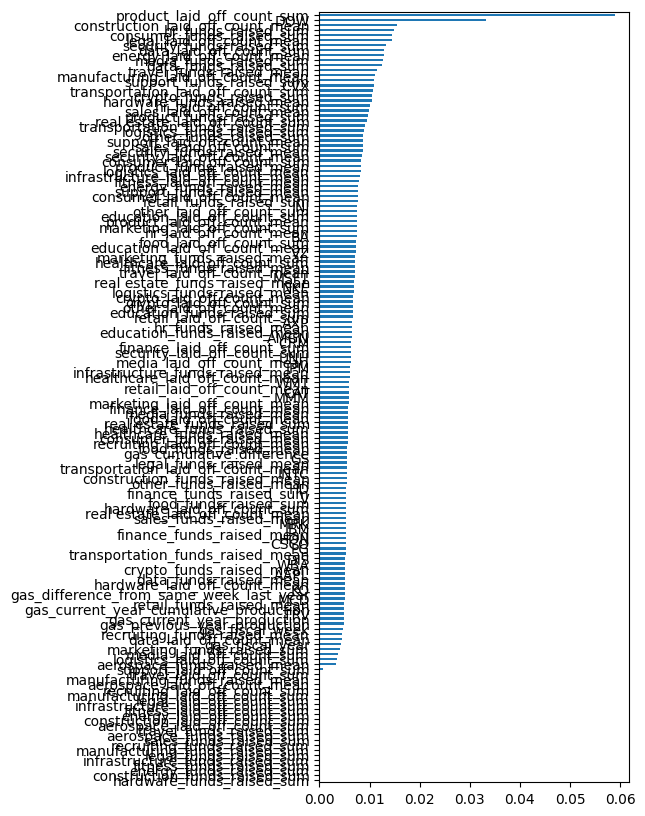

In [71]:
(pd.Series(best_estimator.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(figsize=(4, 10))
)